In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from time import time
from arch import arch_model

from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

**PART1**

In [10]:
etherium = 'ETH-USD'
start_date = datetime(2021,7,1)
train_end_date = datetime(2023,7,1)
end_date = datetime(2023,12,1)

In [11]:
etherium_tickerDf = yf.Ticker(etherium)
etherium_tickerDf = etherium_tickerDf.history(period='1d', start=start_date, end=end_date)
etherium_close = etherium_tickerDf['Close']

In [12]:
train_bitcoin = etherium_close[start_date:end_date]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24464\2822180101.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  train_bitcoin = etherium_close[start_date:end_date]


**PART2**

In [13]:
p_len = 6
q_len = 6
d = 0
def best_arima_combo(train_data):
    # combo = list(itertools.product(p_range, [0], q_range))  # Assuming d=0 for no differencing
    best_aic = float("inf")
    best_order = None
    best_model = None
    for p in range(p_len):
        for q in range(q_len):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_model = model_fit
                    best_order = (p, d, q)
            except:
                continue

    return best_order,best_model



In [14]:
window_size =  (train_end_date  - start_date).days
means = []
residuals = []

**Train Model**

In [15]:
# https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html

def train_models(train_data):
    for i in range(len(train_data) - window_size):
        window_data = train_data.iloc[i:i + window_size + 1]

        # best arima order and model
        best_order,best_arima_model = best_arima_combo(window_data)
        # best_arima_model = ARIMA(window_data, order=best_order).fit()
        residual = best_arima_model.resid
        residuals.append(residual)
        
        # train garch
        garch_model= arch_model(residual, vol='Garch', p=best_order[0], q=best_order[2])
        garch_fit = garch_model.fit()
        garch_forecast = garch_fit.forecast(horizon=1)
        garch_mean = garch_forecast.mean
        means.append(garch_mean.iloc[-1])
    
    data = [m[0] for m in means]
    return pd.DataFrame(data, columns=['Mean'], index=train_data.loc[train_end_date:end_date].index)

    

In [16]:
#ETH
train_results = train_models(train_bitcoin)

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4688.652543482009
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4297.256201360948
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4267.047398114912
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4304.77033423919
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4263.732935357171
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4278.734162413099
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4263.5140639997535
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4263.495398670412
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4263.494136290858
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4263.4886966707
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4263.477080883364
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4263.442532501813
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4263.361551645455
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4263.1561531

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4687.012632515434
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4296.265900818662
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4265.785052923438
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4290.523472347388
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4262.561670062457
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4276.535994703948
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4264.589277783462
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4262.325288651226
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4262.290293903624
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4262.289264715606
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4262.2835956521285
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4262.255154185701
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4262.115159721455
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4261.4643

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4683.773804485665
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4294.834916949159
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4264.01116152555
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4286.240911305803
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4260.751066588203
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4274.823541034563
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4262.2436040329485
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4260.522069029218
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4260.489204779853
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4260.488151112861
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4260.482201312863
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4260.452295396529
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4260.304782835381
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4259.61906

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4682.30755794731
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4293.0693375430865
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4262.643107415965
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4279.212149623836
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4259.263608348086
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4273.194067396553
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4260.074060222036
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4259.029885960041
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4259.0222466841515
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4259.0214599270785
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4259.0164679816335
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4258.988415784825
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4258.835386235864
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4258.06

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4683.521803906683
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4292.674297475362
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4261.792062682174
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4278.918918457281
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4258.263882957207
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4271.7593325916605
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4259.7912691490765
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4258.044101057764
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4257.969893628537
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4257.969012867636
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4257.963737694254
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4257.934556205368
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4257.782622533393
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4257.060

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4679.872175725759
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4291.036223486936
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4260.670728011892
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4310.140097838688
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4257.558617926925
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4275.273108125666
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4257.342607296605
Iteration:      8,   Func. Count:     70,   Neg. LLF: 4257.32204934619
Iteration:      9,   Func. Count:     78,   Neg. LLF: 4257.321080809015
Iteration:     10,   Func. Count:     86,   Neg. LLF: 4257.318674615907
Iteration:     11,   Func. Count:     94,   Neg. LLF: 4257.312468718582
Iteration:     12,   Func. Count:    102,   Neg. LLF: 4257.295947474631
Iteration:     13,   Func. Count:    110,   Neg. LLF: 4257.252983335886
Iteration:     14,   Func. Count:    118,   Neg. LLF: 4257.138796

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4682.56160045979
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4291.065001368971
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4260.2665151972715
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4296.794535532801
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4256.9109957429155
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4272.730133590187
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4256.672048053602
Iteration:      8,   Func. Count:     70,   Neg. LLF: 4256.664658003833
Iteration:      9,   Func. Count:     78,   Neg. LLF: 4256.663816580088
Iteration:     10,   Func. Count:     86,   Neg. LLF: 4256.65828521501
Iteration:     11,   Func. Count:     94,   Neg. LLF: 4256.645314560232
Iteration:     12,   Func. Count:    102,   Neg. LLF: 4256.609808037286
Iteration:     13,   Func. Count:    110,   Neg. LLF: 4256.516070072241
Iteration:     14,   Func. Count:    118,   Neg. LLF: 4256.27418

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4681.987800990102
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4289.718227417288
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4258.395958225458
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4282.10205833969
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4255.306300863976
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4270.246635679305
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4255.944237632709
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4255.100770296666
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4255.089477784075
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4255.088683986124
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4255.084051836049
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4255.060145232292
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4254.940471386706
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4254.373444

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4681.754118103886
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4290.210853163328
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4256.763888496555
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4274.7212746851765
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4253.8270679470415
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4262.2807061132735
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4254.142254222625
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4253.708019967568
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4253.7068625882475
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4253.7055593482355
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4253.697679009936
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4253.656862043848
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4253.454025909177
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4252.

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4688.000080570411
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4288.617691699249
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4257.195057125002
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4267.924682464775
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4253.917386437103
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4263.379277307515
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4254.668107562114
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4253.719293240649
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4253.714075235834
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4253.709965730235
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4253.708853304146
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4253.70188675737
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4253.664734967841
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4253.476590

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4687.802649368767
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4289.415903740522
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4255.556247841634
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4263.830853427757
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4252.405442148897
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4256.884990425069
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4252.972528487084
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4252.255090643752
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4252.253739776524
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4252.251921961359
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4252.244823161282
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4252.227080844018
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4252.1810136074
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4252.0646569

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4700.848690177159
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4288.168493748905
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4256.889612382817
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4268.05661401535
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4253.278408470589
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4257.992775512239
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4254.949295319587
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4252.985830497381
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4252.976783078326
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4252.973384350233
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4252.972239677737
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4252.966359419575
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4252.9510501976965
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4252.91064

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4718.962609282168
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4301.932456373841
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4270.948371992223
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4289.491326702279
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4303.519834316119
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4271.907328798689
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4264.116673109971
Iteration:      8,   Func. Count:     79,   Neg. LLF: 4264.175971829883
Iteration:      9,   Func. Count:     89,   Neg. LLF: 4270.705663358614
Iteration:     10,   Func. Count:     99,   Neg. LLF: 4263.387782830621
Iteration:     11,   Func. Count:    108,   Neg. LLF: 4263.401126760425
Iteration:     12,   Func. Count:    118,   Neg. LLF: 4263.372727280155
Iteration:     13,   Func. Count:    128,   Neg. LLF: 4263.357334136509
Iteration:     14,   Func. Count:    137,   Neg. LLF: 4263.35622

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4709.701346954549
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4299.153736081924
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4268.501490563682
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4272.648584821822
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4289.259506559701
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4268.979974511962
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4262.291702855725
Iteration:      8,   Func. Count:     79,   Neg. LLF: 4265.431064691541
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4273.406821209805
Iteration:     10,   Func. Count:    100,   Neg. LLF: 4262.858113783459
Iteration:     11,   Func. Count:    110,   Neg. LLF: 4261.809716430478
Iteration:     12,   Func. Count:    119,   Neg. LLF: 4261.806842970038
Iteration:     13,   Func. Count:    128,   Neg. LLF: 4261.8039204573
Iteration:     14,   Func. Count:    137,   Neg. LLF: 4261.8026779

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4728.7949705204965
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4302.192104423482
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4269.413959347203
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4288.417739356146
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4284.9682436504445
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4442.899794152676
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4263.949072937319
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4282.226038154576
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4263.277967357822
Iteration:     10,   Func. Count:    100,   Neg. LLF: 4263.01736041158
Iteration:     11,   Func. Count:    110,   Neg. LLF: 4262.897928286868
Iteration:     12,   Func. Count:    119,   Neg. LLF: 4262.898088196118
Iteration:     13,   Func. Count:    129,   Neg. LLF: 4262.8923162929905
Iteration:     14,   Func. Count:    138,   Neg. LLF: 4262.891

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4742.242311789003
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4288.470734271024
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4329.069643780671
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4320.066467383804
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4260.254765340233
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4261.039524124778
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4258.445262270978
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4258.421962298886
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4258.416109487355
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4258.415199617279
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4258.411995875116
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4258.406155999443
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4258.391206056656
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4258.35134

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4740.859622388234
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4289.319225731111
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4337.986703036101
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4310.404248695317
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4262.425430431519
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4257.330395224132
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4257.300534917421
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4284.2943409883765
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4257.017877049728
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4257.007459708579
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4257.006352651004
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4256.999612271365
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4256.964452044723
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4256.7845

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4680.016301689919
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5018.3622205046095
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4598.314908099836
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4275.151335429075
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4263.480779428353
Iteration:      6,   Func. Count:     61,   Neg. LLF: 4259.463981218611
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4270.6532505811665
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4269.667409489328
Iteration:      9,   Func. Count:     92,   Neg. LLF: 4259.847129545831
Iteration:     10,   Func. Count:    102,   Neg. LLF: 4257.935454989269
Iteration:     11,   Func. Count:    111,   Neg. LLF: 4257.897983280772
Iteration:     12,   Func. Count:    120,   Neg. LLF: 4257.884917902866
Iteration:     13,   Func. Count:    129,   Neg. LLF: 4257.878455431177
Iteration:     14,   Func. Count:    138,   Neg. LLF: 4257.875

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4766.8467226450775
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4299.555696917002
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4419.3434148045035
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4285.309681951686
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4298.913844141787
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4262.728958757367
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4263.779552807256
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4261.643497669707
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4329.113800715945
Iteration:     10,   Func. Count:    100,   Neg. LLF: 4261.063714454194
Iteration:     11,   Func. Count:    109,   Neg. LLF: 4261.059701094345
Iteration:     12,   Func. Count:    119,   Neg. LLF: 4261.039827252851
Iteration:     13,   Func. Count:    128,   Neg. LLF: 4261.037723793431
Iteration:     14,   Func. Count:    137,   Neg. LLF: 4261.032

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4781.91033229467
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4286.978035591217
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4366.1790171775465
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4281.0897065911895
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4262.163779525663
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4256.507340654867
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4337.58894786319
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4259.371563665318
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4255.82022893988
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4255.800929822813
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4255.797040723262
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4255.795494407662
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4255.785915625342
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4255.734366

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4720.698090703734
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4281.693012798731
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4326.798964660538
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4323.440793143336
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4253.532912959968
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4250.536599590392
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4249.984176565103
Iteration:      8,   Func. Count:     70,   Neg. LLF: 4282.706661338562
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4249.881767962596
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4249.8232595617
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4249.820721900973
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4249.819234026712
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4249.810614560512
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4249.7662596

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4717.605979879265
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4279.521165540662
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4321.09752781771
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4326.670004196749
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4251.147088995762
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4249.399520391599
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4248.411484355362
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4248.344656563744
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4248.304342694927
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4248.3029577906
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4248.295542406362
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4248.289826284423
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4248.275645214046
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4248.23758063

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4705.027604427709
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4277.480812411177
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4246.669843207406
Iteration:      4,   Func. Count:     35,   Neg. LLF: 4320.136953386416
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4248.050503793995
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4284.188265470064
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4245.8337646776645
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4245.722499959849
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4245.713667508625
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4245.711851299029
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4245.7097450100655
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4245.700873367109
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4245.680795561195
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4245.624

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4702.136127377689
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4276.054675132273
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4247.424585653163
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4406.952780875319
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4244.962916429816
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4250.2412856931915
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4245.300639135714
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4244.2837708856
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4244.277962163024
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4244.276001403439
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4244.274267433846
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4244.264761988902
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4244.242414074377
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4244.183019

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4706.062742789941
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4275.116627321979
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4246.616105914647
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4594.40680248674
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4243.99600405556
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4250.124939695315
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4244.391936083951
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4243.347568020878
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4243.301269083045
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4243.293611613609
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4243.292431952076
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4243.284615676544
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4243.240932622688
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4243.0073799

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4708.133246355112
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4274.093892406272
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4310.094190452443
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4434.957172239989
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4244.304748766923
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4243.074513175699
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4242.139843402142
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4242.079928858508
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4242.080497433775
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4242.075161966149
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4242.073112816861
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4242.058182209135
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4242.019109724553
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4241.91354

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     14,   Neg. LLF: 13886.888436538109
Iteration:      2,   Func. Count:     27,   Neg. LLF: 31098.530463589777
Iteration:      3,   Func. Count:     42,   Neg. LLF: 13886.52696542388
Iteration:      4,   Func. Count:     55,   Neg. LLF: 13886.4883624522
Iteration:      5,   Func. Count:     68,   Neg. LLF: 13886.488357314502
Iteration:      6,   Func. Count:     80,   Neg. LLF: 13886.48835897162
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13886.488357314502
            Iterations: 6
            Function evaluations: 80
            Gradient evaluations: 6


d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4715.098463770997
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4272.092588095618
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4315.596301230288
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4310.4256998158335
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4240.120753749879
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4244.132021013916
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4251.14370144834
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4239.69831434507
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4239.624666262154
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4239.621154436965
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4239.619251571161
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4239.616945425674
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4239.600595887812
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4239.505830

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4721.439121259893
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4271.1389529975395
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4319.617889878914
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4327.3347677222355
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4238.7961839513955
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4243.815172925277
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4239.212594467057
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4238.48438485125
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4238.466338506289
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4238.464111498803
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4238.462090178748
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4238.45801717764
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4238.445145886733
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4238.4132

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4731.533814548613
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4270.665398545967
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4328.697071888599
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4381.29680012031
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4237.8510184035595
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4247.852071688516
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4237.734446672243
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4237.535957170997
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4237.5236159751485
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4237.520729340727
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4237.5190356722305
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4237.508600882225
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4237.45465992299
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4237.1844

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4744.938550114107
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4270.128281472141
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4344.864055789738
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4703.945183589729
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4237.779837470969
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4246.969257501298
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4265.853266293874
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4236.967910965095
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4236.716393517275
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4236.642442759401
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4236.6303269245145
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4236.628177844812
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4236.623716063477
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4236.6172

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4755.304058849868
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4269.744346335956
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4355.8286937183875
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6907.216834469586
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4236.205275082579
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4240.213017705888
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4237.839495060294
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4235.523726072266
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4235.43769820369
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4235.422088393467
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4235.42033493704
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4235.416613190438
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4235.4019543081085
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4235.36854

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4769.189030742729
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4269.312574902016
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4385.166807886772
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6767.582740350853
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4236.013001025478
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4241.703816003817
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4267.512865823895
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4235.21295688059
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4234.894400051338
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4234.8333043507455
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4234.809021687324
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4234.806870861175
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4234.801962745417
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4234.79583

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4753.894726600387
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4266.860407042457
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4360.105660370815
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5932.1744213403235
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4233.448472412004
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4244.732955131019
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4310.232645263959
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4232.106031960603
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4232.01382383381
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4231.980413192585
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4231.971493884841
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4231.969679598094
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4231.958558352144
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4231.90231

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4791.881320850931
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4266.884041295254
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4454.38982443738
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5796.561177440865
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4233.979237974649
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4265.875865951541
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4288.725165060558
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4232.508045913026
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4232.367139874863
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4232.310552346347
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4232.308837540922
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4232.300535842795
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4232.2871299105645
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4232.24132

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4822.537555669496
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4268.823254347352
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4798.097773113114
Iteration:      4,   Func. Count:     36,   Neg. LLF: 6029.209846928752
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4233.024647251454
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4235.799627298308
Iteration:      7,   Func. Count:     64,   Neg. LLF: 5655.424598050795
Iteration:      8,   Func. Count:     74,   Neg. LLF: 4232.348413071906
Iteration:      9,   Func. Count:     83,   Neg. LLF: 4232.020386580498
Iteration:     10,   Func. Count:     91,   Neg. LLF: 4231.9696418227595
Iteration:     11,   Func. Count:     99,   Neg. LLF: 4231.959937323255
Iteration:     12,   Func. Count:    107,   Neg. LLF: 4231.956401031364
Iteration:     13,   Func. Count:    115,   Neg. LLF: 4231.953068054317
Iteration:     14,   Func. Count:    123,   Neg. LLF: 4231.9419

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4847.157405484728
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4267.011020533662
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5404.490210401753
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4447.821989873707
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4231.75165154515
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4235.246379166425
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4269.918810904323
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4231.365056938739
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4231.0998202386645
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4231.082565422592
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4231.05882998067
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4231.056624708808
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4231.051768449644
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4231.038641

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4930.123650242801
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4269.161495113755
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4866.089441003577
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4276.259716238893
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4235.993971283149
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4257.821308058801
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4412.210324946603
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4237.050311104057
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4234.985853613332
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4234.892929725015
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4234.877190773795
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4234.874520824278
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4234.871245677141
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4234.85980

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4878.591370255963
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4266.341790284691
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5618.338765656739
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4334.782884739076
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4232.086151266977
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4235.0480384677685
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4286.7844832852
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4232.038811770717
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4231.380945720031
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4231.371407862724
Iteration:     11,   Func. Count:     98,   Neg. LLF: 4231.359458144254
Iteration:     12,   Func. Count:    106,   Neg. LLF: 4231.357429107819
Iteration:     13,   Func. Count:    114,   Neg. LLF: 4231.347849577069
Iteration:     14,   Func. Count:    122,   Neg. LLF: 4231.330174

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4933.74361681566
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4264.895219486153
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4621.737894949066
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4265.854855482341
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4234.999345378519
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4240.254008221844
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4231.892772013988
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4231.823155875279
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4231.869974287889
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4231.812634858668
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4231.740106351217
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4231.737989019401
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4231.731629294829
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4231.715675

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4928.281921611924
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4263.834842073499
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4643.5258413499705
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4262.939263168706
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4230.846867868147
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4263.365692674636
Iteration:      7,   Func. Count:     62,   Neg. LLF: 5595.433738425889
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4229.514580727806
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4229.334906814638
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4229.306602002609
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4229.297325101844
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4229.29444580493
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4229.290221407057
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4229.27643

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4941.000509856579
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4260.089542605821
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4403.125037473907
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4238.349626329589
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4247.0450885592745
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4228.287380496322
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4239.707383621114
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4227.917260095603
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4227.905201352617
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4227.902635008014
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4227.899269812302
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4227.876477350168
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4227.808387814468
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4227.6654

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4899.051055392976
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4259.398894757911
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4453.899252203995
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4245.466991778523
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4227.234965119445
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4242.208519740925
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4224.602936123888
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4224.4783923180785
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4224.447539949129
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4224.435769741365
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4224.433857971753
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4224.421094733874
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4224.349847403637
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4223.9689

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20902.81182498295
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4264.455577103325
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4296.6494497587555
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4258.873083186206
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4228.043588090743
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4231.883217913518
Iteration:      7,   Func. Count:     65,   Neg. LLF: 4238.063573699118
Iteration:      8,   Func. Count:     74,   Neg. LLF: 4227.049315058142
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4226.818013163385
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4233.830119091612
Iteration:     11,   Func. Count:     99,   Neg. LLF: 4226.749192859433
Iteration:     12,   Func. Count:    107,   Neg. LLF: 4226.746115066497
Iteration:     13,   Func. Count:    115,   Neg. LLF: 4226.74253629045
Iteration:     14,   Func. Count:    123,   Neg. LLF: 4226.73292

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20897.354683950594
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4265.313495935691
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4291.570489154143
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4254.90549929695
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4224.481604372844
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4224.918160233578
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4224.126027004505
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4223.849071237219
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4223.74358346028
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4223.739593924969
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4223.73702361657
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4223.7228049901505
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4223.692954648688
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4223.605578

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20902.073686765827
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4260.473402384272
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4235.371569344157
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4251.027987152862
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4223.45728974903
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4236.89076854799
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4225.000640176691
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4222.7225661086795
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4222.683041174196
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4222.680314549274
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4222.677465625347
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4222.661004714348
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4222.5766195907945
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4222.1594

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 7812.995707761847
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4255.784288194307
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4306.356233151673
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4254.987586709989
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4218.852433690083
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4224.671584539261
Iteration:      7,   Func. Count:     65,   Neg. LLF: 4225.095271448476
Iteration:      8,   Func. Count:     74,   Neg. LLF: 4218.104698704356
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4218.083772166956
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4218.0795357621755
Iteration:     11,   Func. Count:     98,   Neg. LLF: 4218.076866498312
Iteration:     12,   Func. Count:    106,   Neg. LLF: 4218.058895304865
Iteration:     13,   Func. Count:    114,   Neg. LLF: 4217.955962614997
Iteration:     14,   Func. Count:    122,   Neg. LLF: 4217.3990

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4884.445785649827
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4886.330489546012
Iteration:      3,   Func. Count:     27,   Neg. LLF: 5005.383180881252
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4251.638131419062
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4223.633136627821
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4221.211032032098
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4240.328311997857
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4224.460583697301
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4220.834395748017
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4220.831294915473
Iteration:     11,   Func. Count:     98,   Neg. LLF: 4220.829104392706
Iteration:     12,   Func. Count:    106,   Neg. LLF: 4220.822847227466
Iteration:     13,   Func. Count:    114,   Neg. LLF: 4220.806766871276
Iteration:     14,   Func. Count:    122,   Neg. LLF: 4220.76544

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4891.589500861951
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4887.246496948618
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6771.802561127943
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4259.135353160515
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4220.848688606233
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4237.787993118684
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4289.892173793337
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4219.3607143022355
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4219.241501859491
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4219.191282365786
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4219.188835190544
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4219.187242729428
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4219.177141773835
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4219.1539

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 20883.84383008927
Iteration:      2,   Func. Count:     25,   Neg. LLF: 4229.253963413743
Iteration:      3,   Func. Count:     37,   Neg. LLF: 4240.110544348808
Iteration:      4,   Func. Count:     49,   Neg. LLF: 4231.573684400766
Iteration:      5,   Func. Count:     61,   Neg. LLF: 4257.282413503123
Iteration:      6,   Func. Count:     73,   Neg. LLF: 4230.38243640335
Iteration:      7,   Func. Count:     85,   Neg. LLF: 4223.450411307469
Iteration:      8,   Func. Count:     97,   Neg. LLF: 4216.253473150029
Iteration:      9,   Func. Count:    108,   Neg. LLF: 4215.483443630945
Iteration:     10,   Func. Count:    119,   Neg. LLF: 4215.47439594874
Iteration:     11,   Func. Count:    131,   Neg. LLF: 4215.443628233654
Iteration:     12,   Func. Count:    143,   Neg. LLF: 4215.421236891142
Iteration:     13,   Func. Count:    154,   Neg. LLF: 4215.420314646427
Iteration:     14,   Func. Count:    165,   Neg. LLF: 4215.4188877

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20895.752781368286
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4599.14412399051
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4244.133717723591
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4246.232232879027
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4220.895366961407
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4221.874682557088
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4225.613521262899
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4219.498353693085
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4219.330138522797
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4219.189179055749
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4219.122235181888
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4219.115307207325
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4219.114201424551
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4219.10729

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4973.964752807933
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4869.217092294947
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4888.258908607844
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4247.53816516864
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4251.254542865715
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4216.969034031417
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4225.948175381842
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4216.833245005992
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4216.797862195938
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4216.769743440491
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4216.762933888058
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4216.761610709213
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4216.753420916243
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4216.736646

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20891.804870753767
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4595.207876655493
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4240.0324767109505
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4258.809153376399
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4217.209778330804
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4218.69324648186
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4220.723921943449
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4215.704695967612
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4215.545038772381
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4215.426102592284
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4215.342594824402
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4215.327044929977
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4215.325649955073
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4215.3225

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20899.615700586182
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4590.082257695546
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4236.29331495466
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4242.226246894406
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4217.1240034015555
Iteration:      6,   Func. Count:     56,   Neg. LLF: 4215.403338565169
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4220.491996609311
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4215.233378644499
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4215.149886235148
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4215.148103105346
Iteration:     11,   Func. Count:     98,   Neg. LLF: 4215.146433516171
Iteration:     12,   Func. Count:    106,   Neg. LLF: 4215.139244413073
Iteration:     13,   Func. Count:    114,   Neg. LLF: 4215.12359335946
Iteration:     14,   Func. Count:    122,   Neg. LLF: 4215.07964

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4964.323390286615
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4868.462815350453
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4894.9927105682655
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4242.196625321649
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4247.104339970497
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4211.731151968023
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4215.134422296169
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4211.623118255247
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4211.616194308469
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4211.610532880454
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4211.601156933878
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4211.599993431447
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4211.593860849549
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4211.5779

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4336.110471469048
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4351.395484790586
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4363.077792985819
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4334.337701084329
Iteration:      5,   Func. Count:     41,   Neg. LLF: 4389.958285095823
Iteration:      6,   Func. Count:     49,   Neg. LLF: 4319.163658212417
Iteration:      7,   Func. Count:     57,   Neg. LLF: 4305.838171452854
Iteration:      8,   Func. Count:     65,   Neg. LLF: 4300.554772915128
Iteration:      9,   Func. Count:     72,   Neg. LLF: 4300.525301334311
Iteration:     10,   Func. Count:     79,   Neg. LLF: 4300.524377226116
Iteration:     11,   Func. Count:     86,   Neg. LLF: 4300.523989388081
Iteration:     12,   Func. Count:     93,   Neg. LLF: 4300.523277350957
Iteration:     13,   Func. Count:    100,   Neg. LLF: 4300.520992271373
Iteration:     14,   Func. Count:    107,   Neg. LLF: 4300.52036

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4333.152443401499
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4351.197763755261
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4362.001765795496
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4342.279859887507
Iteration:      5,   Func. Count:     42,   Neg. LLF: 4354.330461595313
Iteration:      6,   Func. Count:     50,   Neg. LLF: 4319.77745034711
Iteration:      7,   Func. Count:     58,   Neg. LLF: 4299.065857594345
Iteration:      8,   Func. Count:     66,   Neg. LLF: 4296.65086822008
Iteration:      9,   Func. Count:     73,   Neg. LLF: 4296.6317127652255
Iteration:     10,   Func. Count:     80,   Neg. LLF: 4296.630774678743
Iteration:     11,   Func. Count:     87,   Neg. LLF: 4296.6303421503
Iteration:     12,   Func. Count:     94,   Neg. LLF: 4296.6293695578115
Iteration:     13,   Func. Count:    101,   Neg. LLF: 4296.628130925707
Iteration:     14,   Func. Count:    108,   Neg. LLF: 4296.6271268

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20891.65003723595
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4583.091514940747
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4231.251343884356
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4245.371812818848
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4210.25724132802
Iteration:      6,   Func. Count:     56,   Neg. LLF: 4208.634975615863
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4211.251625770974
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4208.44329554187
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4208.370112785656
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4208.368935744724
Iteration:     11,   Func. Count:     98,   Neg. LLF: 4208.36371031616
Iteration:     12,   Func. Count:    106,   Neg. LLF: 4208.351500514579
Iteration:     13,   Func. Count:    114,   Neg. LLF: 4208.3171625006
Iteration:     14,   Func. Count:    122,   Neg. LLF: 4208.2316424974

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20889.17874450772
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4580.96661438026
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4232.041226286318
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4248.045128642532
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4207.8611584642695
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4208.406150626886
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4209.870699903821
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4206.395762162304
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4206.250884702415
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4206.184327433279
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4206.0926137986025
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4206.079858114188
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4206.0772279971625
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4206.075

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20887.66345744949
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4577.717083975818
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4229.652277397636
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4235.126256133269
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4207.488306812589
Iteration:      6,   Func. Count:     56,   Neg. LLF: 4205.8759094127545
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4223.3715577665735
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4205.773714433003
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4205.765298022903
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4205.7645408561475
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4205.760223372752
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4205.738096513813
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4205.628711424072
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4205.12

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20887.763395799655
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4575.485127667306
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4230.3010582039715
Iteration:      4,   Func. Count:     38,   Neg. LLF: 4232.508966098994
Iteration:      5,   Func. Count:     47,   Neg. LLF: 4205.888990811063
Iteration:      6,   Func. Count:     56,   Neg. LLF: 4204.343894133352
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4207.395495504296
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4204.198445053054
Iteration:      9,   Func. Count:     82,   Neg. LLF: 4204.056522449247
Iteration:     10,   Func. Count:     90,   Neg. LLF: 4204.055662143304
Iteration:     11,   Func. Count:     98,   Neg. LLF: 4204.051891871545
Iteration:     12,   Func. Count:    106,   Neg. LLF: 4204.042838392719
Iteration:     13,   Func. Count:    114,   Neg. LLF: 4204.018606209593
Iteration:     14,   Func. Count:    122,   Neg. LLF: 4203.957

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20909.248145953512
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4242.998301086025
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4240.415286871363
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4233.800730492332
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4206.1109502873
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4205.534553470735
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4204.818390476034
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4204.895347289158
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4204.572824139957
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4204.570000510186
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4204.569171499846
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4204.567609880636
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4204.562275196798
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4204.550156

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20951.041175453014
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4248.360242663612
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4229.337297191203
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4239.006141223388
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4208.695419992856
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4214.461000872614
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4208.4775107135365
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4208.3733132122925
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4208.367336108145
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4208.366191008368
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4208.365465502922
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4208.362624892583
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4208.356512832844
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4208.33

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20945.319518083466
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4246.617417363512
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4225.543831372064
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4236.741846902226
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4206.41462290488
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4224.129977872408
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4206.246442500253
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4206.177554137467
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4206.174964527931
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4206.174211179369
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4206.173177444802
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4206.1696114313
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4206.161284052221
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4206.1391937

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20965.39700966813
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4246.727560794676
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4235.796656058759
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4234.630847677741
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4206.436215458058
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4206.817479764362
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4206.214316764634
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4206.067739255984
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4206.059712613051
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4206.058138391663
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4206.057327133463
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4206.056112921507
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4206.053344125514
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4206.04602

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20958.73568054006
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4245.910162938812
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4230.909105266693
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4229.299715700982
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4203.907492794612
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4204.04453079682
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4203.668871291296
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4203.638782463241
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4203.631249435932
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4203.628215020494
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4203.627620366507
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4203.626093122808
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4203.623450587387
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4203.615031

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20968.25242814891
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4244.319188625659
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4244.621149969435
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4214.624596574223
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4203.163694509851
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4203.040137362154
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4202.8837545542665
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4202.621471840725
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4202.588206100727
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4202.58704811467
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4202.5862967633475
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4202.584861922462
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4202.582229558042
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4202.5746

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20965.4947616153
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4245.058154582836
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4240.290563656117
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4204.929081036162
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4201.990869857821
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4200.591090477819
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4200.610088910944
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4200.383598333766
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4200.324970995662
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4200.323276455114
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4200.322623384896
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4200.321114759318
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4200.318851358761
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4200.312223

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20888.671462092563
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4230.314229829404
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4227.161004199513
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4219.854916848079
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4193.441046893923
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4191.977419939068
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4191.7064743942465
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4191.652376077607
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4191.651373623288
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4191.649110201987
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4191.648357959701
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4191.6433465539685
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4191.617867923873
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4191.57

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20897.91617010139
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4232.280815752321
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4204.980952730403
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4214.661266766354
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4191.039435396247
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4212.090970523331
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4190.756889429725
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4190.656069756335
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4190.654038171015
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4190.653400460071
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4190.649380777091
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4190.629453445384
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4190.599381023615
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4190.50030

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20888.035764140437
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4280.3448778652655
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4301.084875336325
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4194.858072752226
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4189.660450524669
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4230.720303250104
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4186.1189894406325
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4188.1820315452205
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4185.925459353416
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4185.912157628952
Iteration:     11,   Func. Count:    119,   Neg. LLF: 4185.911077256057
Iteration:     12,   Func. Count:    129,   Neg. LLF: 4185.91057837585
Iteration:     13,   Func. Count:    139,   Neg. LLF: 4185.909422218272
Iteration:     14,   Func. Count:    149,   Neg. LLF: 4185.90

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20861.12885549454
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4277.607210061804
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4324.666218278936
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4181.75707241736
Iteration:      5,   Func. Count:     55,   Neg. LLF: 4197.825003704061
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4407.769676877264
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4208.611436320687
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4181.11365663737
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4180.635115226026
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4179.752403051023
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4179.728537923997
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4179.6795807893905
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4179.676019271225
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4179.674217

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20867.87576547165
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4271.881053619552
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4335.890081654003
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4202.8081111127385
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4203.706845087391
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4186.192358047376
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4181.209103617264
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4183.562351099479
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4180.29287025542
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4180.229255031118
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4180.228333010917
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4180.228058757441
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4180.226374427784
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4180.22273

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20882.866595134932
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4276.536978709393
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4296.960101860637
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4193.58149338361
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4185.979170414475
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4218.960267837891
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4183.242280351298
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4184.4075053052
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4183.821784648317
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4182.844078413826
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4182.795727703597
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4182.791844381791
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4182.790654661778
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4182.7898542

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20867.415765902508
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4271.131576189759
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4276.766018184122
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4185.563161004517
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4183.454737625741
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4249.952306482823
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4179.736624209805
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4180.454334632846
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4179.627645269769
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4179.637118256254
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4179.624524212471
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4179.622376909549
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4179.617811045865
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4179.6045

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20884.51292625083
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4278.427631826116
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4284.296920170139
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4189.58586829422
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4183.108789100006
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4226.864957991154
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4180.627792682347
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4181.91879393797
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4180.497647172066
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4180.494397519255
Iteration:     11,   Func. Count:    119,   Neg. LLF: 4180.491863300949
Iteration:     12,   Func. Count:    129,   Neg. LLF: 4180.490185252179
Iteration:     13,   Func. Count:    139,   Neg. LLF: 4180.48873520694
Iteration:     14,   Func. Count:    149,   Neg. LLF: 4180.48788526

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     12,   Neg. LLF: 20909.649296554948
Iteration:      2,   Func. Count:     25,   Neg. LLF: 4234.791285360265
Iteration:      3,   Func. Count:     37,   Neg. LLF: 4245.70775198042
Iteration:      4,   Func. Count:     49,   Neg. LLF: 4175.755433884022
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4175.338418946301
Iteration:      6,   Func. Count:     71,   Neg. LLF: 4174.755620019091
Iteration:      7,   Func. Count:     82,   Neg. LLF: 4174.3538425314155
Iteration:      8,   Func. Count:     93,   Neg. LLF: 4174.143175838049
Iteration:      9,   Func. Count:    104,   Neg. LLF: 4173.875229914673
Iteration:     10,   Func. Count:    115,   Neg. LLF: 4173.8111688966455
Iteration:     11,   Func. Count:    126,   Neg. LLF: 4284.185744195788
Iteration:     12,   Func. Count:    140,   Neg. LLF: 4173.777181155061
Iteration:     13,   Func. Count:    151,   Neg. LLF: 4173.768167895951
Iteration:     14,   Func. Count:    162,   Neg. LLF: 4173.767

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20902.309109021797
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4287.481817897793
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4311.4780966346
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4198.343087756884
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4182.821451511469
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4185.841903541804
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4177.856043289728
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4179.62806936231
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4178.956796866763
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4177.467996771762
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4177.463468067843
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4177.461190649719
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4177.459616183449
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4177.4593347

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20877.92565784527
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4279.542255970107
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4318.671374224265
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4194.737703382092
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4179.96356068775
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4184.28875136103
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4174.590033524119
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4174.920608795445
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4175.838696236575
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4174.062208246292
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4174.056685627676
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4174.053935591942
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4174.052665211122
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4174.0524271

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20882.971510362087
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4281.878028097543
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4262.067266245271
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4197.29818024336
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4177.483613144308
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4188.344973499423
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4172.691940241746
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4174.227326602511
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4173.10254512574
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4172.231155663495
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4172.227697702156
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4172.22647774182
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4172.225410104777
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4172.2251342

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20869.5813593567
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4283.385544514584
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4324.668571451279
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4185.166670149525
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4174.29387321931
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4197.254137266468
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4169.6328423625155
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4170.027639602261
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4170.897564811843
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4169.1220838276195
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4169.097652570171
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4169.097044805443
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4169.096065573467
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4169.09539

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4875.119036766659
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4179.6302498854375
Iteration:      3,   Func. Count:     27,   Neg. LLF: 6841.2855079016335
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4184.411076932751
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4171.759754804399
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4156.632363674693
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4162.254897996355
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4156.1500407727135
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4156.101018719041
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4156.097326825005
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4156.095111161532
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4156.093056226986
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4156.085744383563
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4156.06

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20806.006512621912
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4221.701833365564
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4165.3740576554555
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4169.036868200079
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4148.680645639771
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4155.196767186542
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4195.605263975864
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4152.442507722176
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4146.6917596909025
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4162.327039076962
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4146.594494416206
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4146.588911087066
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4146.585868135971
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4146.57

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 22521.59465221351
Iteration:      2,   Func. Count:     27,   Neg. LLF: 5768.015784641882
Iteration:      3,   Func. Count:     39,   Neg. LLF: 5764.866853410138
Iteration:      4,   Func. Count:     51,   Neg. LLF: 5748.355715998178
Iteration:      5,   Func. Count:     63,   Neg. LLF: 5645.517480896204
Iteration:      6,   Func. Count:     75,   Neg. LLF: 5606.028943611442
Iteration:      7,   Func. Count:     88,   Neg. LLF: 5397.233309989802
Iteration:      8,   Func. Count:    100,   Neg. LLF: 5396.517161335036
Iteration:      9,   Func. Count:    112,   Neg. LLF: 5395.442010140748
Iteration:     10,   Func. Count:    124,   Neg. LLF: 5395.372619298225
Iteration:     11,   Func. Count:    136,   Neg. LLF: 5395.362307432937
Iteration:     12,   Func. Count:    148,   Neg. LLF: 5395.362167974934
Iteration:     13,   Func. Count:    160,   Neg. LLF: 5395.362159154354
Iteration:     14,   Func. Count:    172,   Neg. LLF: 5395.36212

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20838.12586597198
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4224.376680014409
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4175.831885187785
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4161.410230708795
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4151.213051867859
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4165.277669270636
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4438.400724610563
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4149.275621926555
Iteration:      9,   Func. Count:     98,   Neg. LLF: 4149.011519314865
Iteration:     10,   Func. Count:    108,   Neg. LLF: 4153.783845832252
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4148.961035575879
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4148.886311641971
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4148.880108639825
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4148.87741

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20812.33993046342
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4211.975005964719
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4162.435579170985
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4181.5721034564995
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4143.460474711851
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4157.755230753099
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4184.057067718859
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4142.613129793799
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4141.988056272591
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4142.642904889186
Iteration:     11,   Func. Count:    122,   Neg. LLF: 4141.871054251576
Iteration:     12,   Func. Count:    132,   Neg. LLF: 4141.860918582699
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4141.856506164722
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4141.8528

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20812.144863994898
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4213.618759838003
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4160.250991185684
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4167.819219973092
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4141.9653514618485
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4156.028293098518
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4173.255817747895
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4142.3072652629235
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4140.424564807864
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4157.460459440166
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4140.363006608568
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4140.3627677289205
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4140.355301883317
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4140.3

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20825.41358248826
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4217.801165050395
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4166.808375160396
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4171.030178041678
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4144.229678386618
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4153.796112828923
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4174.339623528642
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4143.363618456414
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4141.869488794068
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4148.2452381755165
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4141.773459986592
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4141.769205043171
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4141.762165037434
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4141.7514

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20811.915792771084
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4209.577505121689
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4158.540367622001
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4172.628269963236
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4138.3002451049215
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4153.366568245605
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4165.662376173502
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4137.714002574514
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4136.5932153944705
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4141.734282489736
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4136.525234429377
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4136.515839044324
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4136.511923992435
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4136.49

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20799.16053340562
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4202.77038944677
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4160.782282965503
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4153.498172666196
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4135.11189065619
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4136.274518409592
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4134.551083468763
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4179.0628076420035
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4133.81562145462
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4133.7130850932945
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4133.706322481724
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4133.702014818676
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4133.691727155408
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4133.663395

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20803.263255337508
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4202.591903763898
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4152.081208519965
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4150.9428462672295
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4134.848115504148
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4144.454192276709
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4164.3248183785045
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4138.489632816918
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4133.01843857893
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4133.393623114209
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4132.947273730093
Iteration:     12,   Func. Count:    132,   Neg. LLF: 4132.908387236481
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4132.897592842088
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4132.893

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20817.14266130205
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4176.7696735413665
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4140.253339564611
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4159.790508806787
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4134.40629141779
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4140.171306573493
Iteration:      7,   Func. Count:     71,   Neg. LLF: 4138.860639756039
Iteration:      8,   Func. Count:     81,   Neg. LLF: 4132.352532430295
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4149.046049305203
Iteration:     10,   Func. Count:    100,   Neg. LLF: 4132.278192811023
Iteration:     11,   Func. Count:    109,   Neg. LLF: 4132.270679897101
Iteration:     12,   Func. Count:    118,   Neg. LLF: 4132.269632824729
Iteration:     13,   Func. Count:    127,   Neg. LLF: 4132.265351594095
Iteration:     14,   Func. Count:    136,   Neg. LLF: 4132.24878

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20847.253116648724
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4213.730749707431
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4166.486038003779
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4155.278010602584
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4140.381880366117
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4151.926392631237
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4222.170987355353
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4138.916316812844
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4138.703733528095
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4140.02727193555
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4138.6826217830585
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4138.472588230299
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4138.464724461617
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4138.4619

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20858.413922435997
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4211.04453485045
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4169.377120221179
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4157.165222531508
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4140.986212628393
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4152.4407627472865
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4173.635327324788
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4139.821135394959
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4139.612930319039
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4141.036421046898
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4139.47781662694
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4139.29862488695
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4139.235110340521
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4139.233206

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20862.28342804885
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4211.973989166319
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4170.921493428963
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4179.720061829913
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4140.408146459706
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4154.115375570347
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4154.882221237012
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4139.657276680871
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4138.684336731256
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4138.580795449241
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4139.166585172747
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4138.467029482694
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4138.464088101663
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4138.45983

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20857.43242023013
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4210.653410849243
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4167.857333963939
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4158.946962351667
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4138.7852815020615
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4147.134428590727
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4171.699912283755
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4137.3253438908705
Iteration:      9,   Func. Count:     98,   Neg. LLF: 4138.151984498092
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4137.42958381205
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4136.817687946948
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4136.813245746154
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4136.809462263145
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4136.7968

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20876.408046771037
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4216.305213508753
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4174.895238357115
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4143.299410245381
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4139.508039757281
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4177.6609145975835
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4295.972891950483
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4138.290513583626
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4141.681569384424
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4138.030557298567
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4137.976904815341
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4137.976751458049
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4137.967127375285
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4137.963

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20885.575939460927
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4210.026420837422
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4182.673024210754
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4139.715515216067
Iteration:      5,   Func. Count:     55,   Neg. LLF: 4144.291034788145
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4141.504902373814
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4136.485210115059
Iteration:      8,   Func. Count:     87,   Neg. LLF: 4136.367366501696
Iteration:      9,   Func. Count:     97,   Neg. LLF: 4146.064953582387
Iteration:     10,   Func. Count:    108,   Neg. LLF: 4136.021273957664
Iteration:     11,   Func. Count:    118,   Neg. LLF: 4136.007927523813
Iteration:     12,   Func. Count:    129,   Neg. LLF: 4136.225344104798
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4135.899849805456
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4135.8972

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20887.091547179738
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4214.7475061363875
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4183.9879364373965
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4147.468171412207
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4137.824143488527
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4190.594012849121
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4159.12815414895
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4135.788440138142
Iteration:      9,   Func. Count:     98,   Neg. LLF: 4138.851253020408
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4135.68116771413
Iteration:     11,   Func. Count:    119,   Neg. LLF: 4135.666383665864
Iteration:     12,   Func. Count:    129,   Neg. LLF: 4135.662504360758
Iteration:     13,   Func. Count:    139,   Neg. LLF: 4135.659810804251
Iteration:     14,   Func. Count:    149,   Neg. LLF: 4135.6497

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20883.731294909925
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4211.580461545656
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4181.77030517717
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4140.049128416406
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4135.065975488048
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4198.534261244243
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4160.166971962526
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4133.371878197695
Iteration:      9,   Func. Count:     98,   Neg. LLF: 4133.389476342381
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4133.332632800858
Iteration:     11,   Func. Count:    119,   Neg. LLF: 4133.329739814358
Iteration:     12,   Func. Count:    129,   Neg. LLF: 4133.322443578652
Iteration:     13,   Func. Count:    139,   Neg. LLF: 4133.308946504262
Iteration:     14,   Func. Count:    149,   Neg. LLF: 4133.27203

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20885.877019421154
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4213.120025801971
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4180.1629220761815
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4139.889255659083
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4134.715928306494
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4196.834206414904
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4169.96955351309
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4133.328674636042
Iteration:      9,   Func. Count:     98,   Neg. LLF: 4140.585114598066
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4140.9303071825525
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4133.215363807914
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4133.209778448758
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4133.20758105947
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4133.2055

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20863.831046632302
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4207.487343882556
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4164.774058178715
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4138.247204353432
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4133.845727626402
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4146.819639229371
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4133.4111309202035
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4131.504585881705
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4139.506587204567
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4131.121030814714
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4130.93241297161
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4130.924078829517
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4130.901256114874
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4130.8954

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20880.82535286835
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4215.658531398232
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4174.8700487495535
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4136.30057348455
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4133.272462326187
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4188.9690919193345
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4355.815424683675
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4131.286056024945
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4133.520881878609
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4131.252563269708
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4131.255090766619
Iteration:     12,   Func. Count:    132,   Neg. LLF: 4131.18487801091
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4131.179711709387
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4131.17421

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20873.62565824166
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4208.254424014443
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4172.0897767433635
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4139.581578291104
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4130.599898079801
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4158.214671162531
Iteration:      7,   Func. Count:     77,   Neg. LLF: 4137.755918359744
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4128.333646605655
Iteration:      9,   Func. Count:     98,   Neg. LLF: 4128.326443515082
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4128.284304765772
Iteration:     11,   Func. Count:    119,   Neg. LLF: 4128.277541858864
Iteration:     12,   Func. Count:    129,   Neg. LLF: 4128.274704283615
Iteration:     13,   Func. Count:    139,   Neg. LLF: 4128.263239396667
Iteration:     14,   Func. Count:    149,   Neg. LLF: 4128.2369

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20890.219309164328
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4211.006708139128
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4191.911124701263
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4131.260995416624
Iteration:      5,   Func. Count:     55,   Neg. LLF: 4134.267110320898
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4158.57985765488
Iteration:      7,   Func. Count:     79,   Neg. LLF: 4135.848570876703
Iteration:      8,   Func. Count:     90,   Neg. LLF: 4127.0882154653855
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4128.573147942056
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4126.719092827708
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4126.626878683551
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4126.630561183143
Iteration:     13,   Func. Count:    142,   Neg. LLF: 4126.618325898101
Iteration:     14,   Func. Count:    152,   Neg. LLF: 4126.6166

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20916.860080508482
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4187.636252286872
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4247.375074493486
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4353.0323892085225
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4134.360499556295
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4186.61014226571
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4129.554171446875
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4131.076977839195
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4128.249178615311
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4128.18605534812
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4128.146599813837
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4128.131611599069
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4128.130174559003
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4128.12917

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20927.597751333222
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4233.977594051621
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4289.221368132147
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4153.086666201638
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4135.252136752165
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4145.53520220417
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4132.975483788121
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4137.170775003834
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4134.223950877974
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4133.304538554086
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4132.416420706981
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4132.387433679192
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4132.385145343781
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4132.38389

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20924.02402394712
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4213.735896765647
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4262.1538321491935
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4134.445615337396
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4128.253798423065
Iteration:      6,   Func. Count:     66,   Neg. LLF: 4359.089174517988
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4131.292503682557
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4127.30751033491
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4126.084679994877
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4126.003834593082
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4125.987137325106
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4125.9822205765295
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4125.976567226187
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4125.9745

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20927.661345892597
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4185.741187792526
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4248.6085217556665
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4201.075921204686
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4132.105886691393
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4134.055903826726
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4128.028818630454
Iteration:      8,   Func. Count:     89,   Neg. LLF: 4127.077113166211
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4125.817685119552
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4125.787291829818
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4125.932388153769
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4125.703325219428
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4125.700615712034
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4125.699

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20911.143105467352
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4224.191660620886
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4278.386364515665
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4140.147596700523
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4130.228906528277
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4155.602232836068
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4126.355483289466
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4131.521738338726
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4126.214049723872
Iteration:     10,   Func. Count:    109,   Neg. LLF: 4126.2157421799675
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4126.205137731506
Iteration:     12,   Func. Count:    130,   Neg. LLF: 4126.202340466474
Iteration:     13,   Func. Count:    140,   Neg. LLF: 4126.196983251644
Iteration:     14,   Func. Count:    150,   Neg. LLF: 4126.182

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20931.637219296867
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4228.792171957986
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4291.8075582115525
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4141.726195339665
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4127.988636592224
Iteration:      6,   Func. Count:     67,   Neg. LLF: 4150.850385657406
Iteration:      7,   Func. Count:     78,   Neg. LLF: 4125.573740568836
Iteration:      8,   Func. Count:     88,   Neg. LLF: 4128.162968402137
Iteration:      9,   Func. Count:     99,   Neg. LLF: 4129.4336586669815
Iteration:     10,   Func. Count:    110,   Neg. LLF: 4125.072191875273
Iteration:     11,   Func. Count:    120,   Neg. LLF: 4125.058196537946
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4124.993299778135
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4124.980094009145
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4124.97

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     11,   Neg. LLF: 20973.789753330406
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4222.535838503718
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4294.646550955842
Iteration:      4,   Func. Count:     45,   Neg. LLF: 4152.399563222109
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4168.248404180335
Iteration:      6,   Func. Count:     68,   Neg. LLF: 4131.138980901374
Iteration:      7,   Func. Count:     79,   Neg. LLF: 4130.531209042831
Iteration:      8,   Func. Count:     90,   Neg. LLF: 4126.517074145451
Iteration:      9,   Func. Count:    100,   Neg. LLF: 4128.638759590633
Iteration:     10,   Func. Count:    111,   Neg. LLF: 4126.38917570274
Iteration:     11,   Func. Count:    121,   Neg. LLF: 4126.3859320006195
Iteration:     12,   Func. Count:    131,   Neg. LLF: 4126.380242772058
Iteration:     13,   Func. Count:    141,   Neg. LLF: 4126.379585848903
Iteration:     14,   Func. Count:    151,   Neg. LLF: 4126.3757

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20958.560644466343
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4173.8447156533575
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4172.977250224125
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4123.90939067243
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4130.185934860721
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4213.729809292058
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4122.897691036122
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4122.857079247573
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4122.830324963061
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4122.819274068865
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4122.8176818329375
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4122.814486562631
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4122.811286594554
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4122.804

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     10,   Neg. LLF: 22494.129017607975
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5666.662402831056
Iteration:      3,   Func. Count:     29,   Neg. LLF: 5659.794079589832
Iteration:      4,   Func. Count:     38,   Neg. LLF: 5621.571934859818
Iteration:      5,   Func. Count:     47,   Neg. LLF: 5439.780112897528
Iteration:      6,   Func. Count:     56,   Neg. LLF: 5676.48822422306
Iteration:      7,   Func. Count:     66,   Neg. LLF: 5309.990085271922
Iteration:      8,   Func. Count:     75,   Neg. LLF: 5308.367958974608
Iteration:      9,   Func. Count:     84,   Neg. LLF: 5307.99536934818
Iteration:     10,   Func. Count:     93,   Neg. LLF: 5307.981779164698
Iteration:     11,   Func. Count:    102,   Neg. LLF: 5307.981674338389
Iteration:     12,   Func. Count:    111,   Neg. LLF: 5307.981656181906
Iteration:     13,   Func. Count:    120,   Neg. LLF: 5307.981534859999
Iteration:     14,   Func. Count:    129,   Neg. LLF: 5307.981156

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20976.254755437294
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4174.151591808139
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4176.663692405443
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4126.097140857188
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4143.620050403051
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4152.596427180222
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4125.054144314807
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4125.011830349722
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4124.989526600761
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4124.979914813005
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4124.977638038523
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4124.976751271817
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4124.973171060722
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4124.9662

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20962.844465556773
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4165.218609538422
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4162.5748243445205
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4132.707771619418
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4124.859183150526
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4123.560715876252
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4126.632905146525
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4123.1452595779865
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4122.878183120463
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4122.869043485649
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4122.864812024947
Iteration:     12,   Func. Count:    105,   Neg. LLF: 4122.863742889783
Iteration:     13,   Func. Count:    113,   Neg. LLF: 4122.8590582143415
Iteration:     14,   Func. Count:    121,   Neg. LLF: 4122.8

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20983.992077734525
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4172.324320426475
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4180.085903603667
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4123.79939961735
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4141.86409331562
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4153.532500756015
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4122.664606516128
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4122.590687295332
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4122.57371878716
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4122.570345680313
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4122.569446512642
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4122.564459640484
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4122.554553103142
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4122.5434783

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20970.44950697372
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4162.090235760115
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4163.460274305169
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4126.623173998851
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4124.850083465517
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4120.4400792591205
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4121.646961688166
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4120.127849800224
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4119.9284074783145
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4119.90255768652
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4119.900000449812
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4119.898443746173
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4119.895711261499
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4119.8906

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20936.115906786545
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4164.661389974599
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4137.070344837815
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4119.820023472061
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4115.781208979113
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4116.416598316546
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4116.0436223778615
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4115.568300262203
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4115.565648021016
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4115.563548146053
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4115.561934968502
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4115.551883948749
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4115.531267540864
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4115.471

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20990.122822767375
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4160.433067115558
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4183.042274097352
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4119.9095517378955
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4119.809443857105
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4133.746087628645
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4118.59659248912
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4118.4862277411485
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4118.437846885865
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4118.42725293702
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4118.426251113005
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4118.421536546929
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4118.41447371364
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4118.39967

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21009.51900931247
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4171.353717907732
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4228.850388801446
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4123.702335651621
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4119.045132774709
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4176.573523848765
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4120.982963498134
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4117.541437605379
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4117.482120017925
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4117.473397818103
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4117.4725833934035
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4117.467423604512
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4117.438685758869
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4117.2945

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20997.019526294433
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4145.910957833572
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4233.442908495804
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4112.883406186698
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4108.467548828201
Iteration:      6,   Func. Count:     59,   Neg. LLF: 4108.272829818032
Iteration:      7,   Func. Count:     69,   Neg. LLF: 4107.7257223644165
Iteration:      8,   Func. Count:     78,   Neg. LLF: 4107.6891086137075
Iteration:      9,   Func. Count:     87,   Neg. LLF: 4107.68681248553
Iteration:     10,   Func. Count:     96,   Neg. LLF: 4107.684912609873
Iteration:     11,   Func. Count:    105,   Neg. LLF: 4107.68482171922
Iteration:     12,   Func. Count:    114,   Neg. LLF: 4107.684246381565
Iteration:     13,   Func. Count:    123,   Neg. LLF: 4107.68101470161
Iteration:     14,   Func. Count:    132,   Neg. LLF: 4107.66426

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Pro

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20991.347244952165
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4140.963415353196
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4242.494343455399
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4111.064782377849
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4109.596061651086
Iteration:      6,   Func. Count:     59,   Neg. LLF: 4127.543282859752
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4111.394729370834
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4106.412895493764
Iteration:      9,   Func. Count:     89,   Neg. LLF: 4106.253226482984
Iteration:     10,   Func. Count:     98,   Neg. LLF: 4106.236232991658
Iteration:     11,   Func. Count:    107,   Neg. LLF: 4106.23432592545
Iteration:     12,   Func. Count:    116,   Neg. LLF: 4106.233923756818
Iteration:     13,   Func. Count:    125,   Neg. LLF: 4106.233432656883
Iteration:     14,   Func. Count:    134,   Neg. LLF: 4106.23331

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20995.474059698667
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4142.782143701048
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4247.9879047691875
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4110.052854829454
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4105.431222499014
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4669.1476254879535
Iteration:      7,   Func. Count:     71,   Neg. LLF: 4117.318396864163
Iteration:      8,   Func. Count:     81,   Neg. LLF: 4104.734642689662
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4104.613452126388
Iteration:     10,   Func. Count:     99,   Neg. LLF: 4104.600392913471
Iteration:     11,   Func. Count:    108,   Neg. LLF: 4104.598009255153
Iteration:     12,   Func. Count:    117,   Neg. LLF: 4104.597390807221
Iteration:     13,   Func. Count:    126,   Neg. LLF: 4104.5967684679545
Iteration:     14,   Func. Count:    135,   Neg. LLF: 4104.5

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21039.877165625487
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4164.2150940963475
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4245.168785918973
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4121.834959319507
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4114.310519455887
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4160.027639221871
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4116.644187413223
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4112.749270124095
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4112.71249916779
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4112.706497865948
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4112.705575578861
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4112.700214994758
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4112.675172016331
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4112.6075

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21044.05001630625
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4155.139393842939
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4250.097277201568
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4119.7747821851835
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4113.631163616814
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4111.730151029864
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4142.165893053785
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4111.435379912715
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4111.431902435333
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4111.430435350806
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4111.428543679987
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4111.419021082444
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4111.403244247507
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4111.3653

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21032.72099918136
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4158.676268392861
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4237.853245981789
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4117.161768910578
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4110.532819988736
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4165.56027252887
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4112.537671596533
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4108.896107460867
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4108.840364832102
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4108.829789665148
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4108.828922761508
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4108.82432083216
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4108.80284860471
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4108.72004668

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21025.086852606157
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4150.963112793501
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4228.201795790195
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4113.635648862652
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4109.022692167657
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4106.985627192056
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4132.208015916853
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4106.863558793605
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4106.845133377564
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4106.843624110645
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4106.842289908767
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4106.834098478908
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4106.805290989651
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4106.7730

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21028.92677339506
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4153.557833532146
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4235.637646534098
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4113.297715722941
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4107.038551901262
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4167.338219406023
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4108.69728547501
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4105.301742890193
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4105.245604052777
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4105.2235253583385
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4105.2225310060985
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4105.218028524714
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4105.211904247159
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4105.1950

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21047.74274749536
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4149.217360903338
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4244.610969651595
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4113.10560950385
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4106.366046171541
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4104.562932744608
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4139.837110153629
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4104.311510746627
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4104.308620297266
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4104.306992787911
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4104.303764687226
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4104.298727267709
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4104.292211786333
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4104.275686

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21077.652308208053
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4257.470953287904
Iteration:      3,   Func. Count:     27,   Neg. LLF: 4151.289269257537
Iteration:      4,   Func. Count:     36,   Neg. LLF: 4156.710571666098
Iteration:      5,   Func. Count:     45,   Neg. LLF: 4105.857405852013
Iteration:      6,   Func. Count:     53,   Neg. LLF: 4105.364501905704
Iteration:      7,   Func. Count:     62,   Neg. LLF: 4105.504392587298
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4104.58367330719
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4104.492280738965
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4104.480421291522
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4104.476818231218
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4104.474950139063
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4104.472517722979
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4104.46691

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21067.61287121314
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4158.067181657934
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4182.224799718257
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4133.673432140347
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4123.549140266456
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4119.704134598988
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4119.620932932067
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4119.12093998216
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4119.095700309748
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4119.088831271295
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4119.082537065497
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4119.08206040687
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4119.081434674312
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4119.0800286

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Pro

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21051.378160489905
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4156.7241702316915
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4172.681552214223
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4150.297572424193
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4120.438273443104
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4117.933956989449
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4117.300117774417
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4117.191927980903
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4117.165548056813
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4117.124915551619
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4117.117585944937
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4117.1159486922425
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4117.115631484254
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4117.11

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21067.92483021215
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4154.726386343486
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4173.556469276156
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4153.252286471008
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4119.924452495561
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4117.590353050904
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4117.271767325972
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4117.061480642116
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4117.044446138521
Iteration:     10,   Func. Count:     87,   Neg. LLF: 4117.000495789403
Iteration:     11,   Func. Count:     95,   Neg. LLF: 4116.996937891121
Iteration:     12,   Func. Count:    103,   Neg. LLF: 4116.9958130196
Iteration:     13,   Func. Count:    111,   Neg. LLF: 4116.995510720368
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4116.9935779

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 21057.055607470276
Iteration:      2,   Func. Count:     26,   Neg. LLF: 4267.123897074101
Iteration:      3,   Func. Count:     39,   Neg. LLF: 4316.450950303943
Iteration:      4,   Func. Count:     52,   Neg. LLF: 4160.212474074408
Iteration:      5,   Func. Count:     65,   Neg. LLF: 4152.713733939981
Iteration:      6,   Func. Count:     78,   Neg. LLF: 4116.787397016211
Iteration:      7,   Func. Count:     91,   Neg. LLF: 4113.292740177257
Iteration:      8,   Func. Count:    104,   Neg. LLF: 4110.056128076869
Iteration:      9,   Func. Count:    117,   Neg. LLF: 4107.9355006100195
Iteration:     10,   Func. Count:    129,   Neg. LLF: 4113.70989783324
Iteration:     11,   Func. Count:    142,   Neg. LLF: 4107.861114110598
Iteration:     12,   Func. Count:    154,   Neg. LLF: 4107.851631599781
Iteration:     13,   Func. Count:    166,   Neg. LLF: 4107.84566572882
Iteration:     14,   Func. Count:    178,   Neg. LLF: 4107.84537

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 21053.39927179042
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4183.929784570534
Iteration:      3,   Func. Count:     30,   Neg. LLF: 4179.421606893061
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4142.525114871674
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4107.652718974912
Iteration:      6,   Func. Count:     59,   Neg. LLF: 4144.647710736156
Iteration:      7,   Func. Count:     69,   Neg. LLF: 4106.692842011978
Iteration:      8,   Func. Count:     78,   Neg. LLF: 4106.241308858969
Iteration:      9,   Func. Count:     87,   Neg. LLF: 4106.2159433298875
Iteration:     10,   Func. Count:     96,   Neg. LLF: 4106.197609849598
Iteration:     11,   Func. Count:    105,   Neg. LLF: 4106.1958408501
Iteration:     12,   Func. Count:    114,   Neg. LLF: 4106.19434107072
Iteration:     13,   Func. Count:    123,   Neg. LLF: 4106.194243836269
Iteration:     14,   Func. Count:    132,   Neg. LLF: 4106.1942100

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21052.630332284854
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4149.91889046475
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4154.03551872887
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4142.407817512133
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4115.580985164096
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4113.225104352087
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4112.536944554501
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4112.540030783135
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4112.364972343328
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4112.335277622255
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4112.326019967989
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4112.3256744154805
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4112.325153776458
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4112.32337

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     13,   Neg. LLF: 21040.84987593054
Iteration:      2,   Func. Count:     26,   Neg. LLF: 4307.958321270274
Iteration:      3,   Func. Count:     39,   Neg. LLF: 4295.965197172021
Iteration:      4,   Func. Count:     52,   Neg. LLF: 4173.105478030087
Iteration:      5,   Func. Count:     65,   Neg. LLF: 4148.121111487579
Iteration:      6,   Func. Count:     78,   Neg. LLF: 4114.092863741368
Iteration:      7,   Func. Count:     91,   Neg. LLF: 4107.953939248533
Iteration:      8,   Func. Count:    104,   Neg. LLF: 4105.360666837818
Iteration:      9,   Func. Count:    116,   Neg. LLF: 4104.909071601251
Iteration:     10,   Func. Count:    128,   Neg. LLF: 4104.840695207407
Iteration:     11,   Func. Count:    140,   Neg. LLF: 4104.827071132302
Iteration:     12,   Func. Count:    152,   Neg. LLF: 4104.823573463711
Iteration:     13,   Func. Count:    164,   Neg. LLF: 4104.82085734298
Iteration:     14,   Func. Count:    176,   Neg. LLF: 4104.820598

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20980.46261638981
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4130.313935908191
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4115.664358081742
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4105.002486663861
Iteration:      5,   Func. Count:     50,   Neg. LLF: 4103.509399711444
Iteration:      6,   Func. Count:     59,   Neg. LLF: 4117.532462717596
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4106.043384060861
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4101.604155505727
Iteration:      9,   Func. Count:     89,   Neg. LLF: 4101.41624618063
Iteration:     10,   Func. Count:     98,   Neg. LLF: 4101.322815358112
Iteration:     11,   Func. Count:    107,   Neg. LLF: 4101.3145625223115
Iteration:     12,   Func. Count:    116,   Neg. LLF: 4101.311157414521
Iteration:     13,   Func. Count:    125,   Neg. LLF: 4101.30981479937
Iteration:     14,   Func. Count:    134,   Neg. LLF: 4101.308992

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20992.845689172398
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4126.847639273361
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4118.859175723061
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4123.00823576117
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4103.300932840107
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4105.6275293049275
Iteration:      7,   Func. Count:     71,   Neg. LLF: 4102.828136242
Iteration:      8,   Func. Count:     81,   Neg. LLF: 4100.488022273111
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4100.448608623339
Iteration:     10,   Func. Count:     99,   Neg. LLF: 4100.429057590514
Iteration:     11,   Func. Count:    108,   Neg. LLF: 4100.422427787347
Iteration:     12,   Func. Count:    117,   Neg. LLF: 4100.419970791958
Iteration:     13,   Func. Count:    126,   Neg. LLF: 4100.4196714597
Iteration:     14,   Func. Count:    135,   Neg. LLF: 4100.419366508

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20940.012717688012
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4322.1524054184865
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4122.030470709547
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4108.121422819419
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4105.578829008994
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4144.889030441078
Iteration:      7,   Func. Count:     64,   Neg. LLF: 4103.977611248158
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4103.966144675975
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4103.965785070728
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4103.965643280078
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4103.965310993015
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4103.964963402841
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4103.964343732779
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4103.963

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     14,   Neg. LLF: 22382.251047192956
Iteration:      2,   Func. Count:     28,   Neg. LLF: 5452.82781720002
Iteration:      3,   Func. Count:     41,   Neg. LLF: 5415.55789826754
Iteration:      4,   Func. Count:     54,   Neg. LLF: 5293.980382113174
Iteration:      5,   Func. Count:     67,   Neg. LLF: 5224.496032186421
Iteration:      6,   Func. Count:     80,   Neg. LLF: 5220.346287745901
Iteration:      7,   Func. Count:     93,   Neg. LLF: 5219.598772521744
Iteration:      8,   Func. Count:    106,   Neg. LLF: 5219.354292824436
Iteration:      9,   Func. Count:    119,   Neg. LLF: 5219.347414705322
Iteration:     10,   Func. Count:    132,   Neg. LLF: 5219.347356714018
Iteration:     11,   Func. Count:    145,   Neg. LLF: 5219.347332685352
Iteration:     12,   Func. Count:    158,   Neg. LLF: 5219.34720328608
Iteration:     13,   Func. Count:    171,   Neg. LLF: 5219.346968251215
Iteration:     14,   Func. Count:    184,   Neg. LLF: 5219.3456296

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 21009.353278975206
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4124.882368058863
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4124.353208013457
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4156.91045677721
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4098.785530936215
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4097.593367867553
Iteration:      7,   Func. Count:     69,   Neg. LLF: 4097.50958792732
Iteration:      8,   Func. Count:     78,   Neg. LLF: 4097.477115269898
Iteration:      9,   Func. Count:     87,   Neg. LLF: 4097.468224387604
Iteration:     10,   Func. Count:     96,   Neg. LLF: 4097.464220746227
Iteration:     11,   Func. Count:    105,   Neg. LLF: 4097.464014850233
Iteration:     12,   Func. Count:    114,   Neg. LLF: 4097.463605984392
Iteration:     13,   Func. Count:    123,   Neg. LLF: 4097.462602536978
Iteration:     14,   Func. Count:    132,   Neg. LLF: 4097.460014

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20984.82171881445
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4128.209142053898
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4116.652062509552
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4107.147496289277
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4100.309480996075
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4117.840424852244
Iteration:      7,   Func. Count:     71,   Neg. LLF: 4111.752725980517
Iteration:      8,   Func. Count:     81,   Neg. LLF: 4097.752459635329
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4098.846857361366
Iteration:     10,   Func. Count:    100,   Neg. LLF: 4097.674989279405
Iteration:     11,   Func. Count:    109,   Neg. LLF: 4097.65818811497
Iteration:     12,   Func. Count:    118,   Neg. LLF: 4097.656527667073
Iteration:     13,   Func. Count:    127,   Neg. LLF: 4097.6552416455925
Iteration:     14,   Func. Count:    136,   Neg. LLF: 4097.65483

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20952.16385172545
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4134.461398042145
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4134.214721067692
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4124.157376817584
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4104.58746612104
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4102.171993517343
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4102.221808608934
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4102.001526984747
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4101.995163688302
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4101.983958255081
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4101.966562327787
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4101.964625864449
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4101.96429008435
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4101.9639716

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20993.19304921127
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4126.793620630916
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4116.721880204014
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4105.640460127253
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4100.890544194597
Iteration:      6,   Func. Count:     60,   Neg. LLF: 4102.489144900114
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4101.703633754363
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4097.759900381027
Iteration:      9,   Func. Count:     89,   Neg. LLF: 4097.632404778622
Iteration:     10,   Func. Count:     98,   Neg. LLF: 4097.5833190558
Iteration:     11,   Func. Count:    107,   Neg. LLF: 4097.5778516095415
Iteration:     12,   Func. Count:    116,   Neg. LLF: 4097.574008698971
Iteration:     13,   Func. Count:    125,   Neg. LLF: 4097.573719117198
Iteration:     14,   Func. Count:    134,   Neg. LLF: 4097.572808

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20977.0166079712
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4134.215240658804
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4129.349660062748
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4124.086260492082
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4104.123690820348
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4101.880392564234
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4101.879801869981
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4101.626214146714
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4101.622400746806
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4101.622253446998
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4101.622093178527
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4101.621924288193
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4101.621751331658
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4101.621423

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20983.984894964455
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4155.870461847746
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4132.185951531141
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4107.209608945864
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4106.330833567659
Iteration:      6,   Func. Count:     61,   Neg. LLF: 4102.045137470044
Iteration:      7,   Func. Count:     70,   Neg. LLF: 4102.076697514135
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4103.135381041875
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4101.495702068458
Iteration:     10,   Func. Count:     99,   Neg. LLF: 4101.409110706566
Iteration:     11,   Func. Count:    108,   Neg. LLF: 4101.37472720515
Iteration:     12,   Func. Count:    117,   Neg. LLF: 4101.358369442679
Iteration:     13,   Func. Count:    126,   Neg. LLF: 4101.356949879017
Iteration:     14,   Func. Count:    135,   Neg. LLF: 4101.35669

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:     10,   Neg. LLF: 20936.857969437766
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4145.923266960733
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4127.355299590412
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4116.804369275598
Iteration:      5,   Func. Count:     51,   Neg. LLF: 4100.325057353453
Iteration:      6,   Func. Count:     61,   Neg. LLF: 4100.14798700426
Iteration:      7,   Func. Count:     71,   Neg. LLF: 4097.644575397351
Iteration:      8,   Func. Count:     80,   Neg. LLF: 4097.642514359781
Iteration:      9,   Func. Count:     90,   Neg. LLF: 4097.643444819988
Iteration:     10,   Func. Count:    100,   Neg. LLF: 4097.633329702402
Iteration:     11,   Func. Count:    109,   Neg. LLF: 4097.632575435664
Iteration:     12,   Func. Count:    118,   Neg. LLF: 4097.632368431786
Iteration:     13,   Func. Count:    127,   Neg. LLF: 4097.6321544458515
Iteration:     14,   Func. Count:    136,   Neg. LLF: 4097.6320

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20949.835596280253
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4131.345850668336
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4121.554288689026
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4118.227074496258
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4098.863862870597
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4096.302868811084
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4096.09847422052
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4096.103102090296
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4096.094568635754
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4096.093025828186
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4096.0929303260145
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4096.092872577694
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4096.092765388773
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4096.0924

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 20983.823067844434
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4131.773694986744
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4124.091599338662
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4118.544614595243
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4099.410814706256
Iteration:      6,   Func. Count:     55,   Neg. LLF: 4096.691799297611
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4096.487392279032
Iteration:      8,   Func. Count:     71,   Neg. LLF: 4096.413840070596
Iteration:      9,   Func. Count:     79,   Neg. LLF: 4096.424270766229
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4096.4063709260345
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4096.406312799885
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4096.406254523752
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4096.4061547761885
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4096.40

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21009.879247299275
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4134.597172322634
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4117.670105192243
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4112.174949058441
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4098.0244446185425
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4119.603132643337
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4102.253054941898
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4096.516479409729
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4096.407295599076
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4096.399832609161
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4096.397732517202
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4096.394811387782
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4096.392421516744
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4096.391

d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ProgrammingLanguages\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\ProgrammingLanguages

Iteration:      1,   Func. Count:      9,   Neg. LLF: 21043.195909727878
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4133.662403225588
Iteration:      3,   Func. Count:     28,   Neg. LLF: 4131.117818632923
Iteration:      4,   Func. Count:     37,   Neg. LLF: 4130.096293234864
Iteration:      5,   Func. Count:     46,   Neg. LLF: 4098.855739079021
Iteration:      6,   Func. Count:     54,   Neg. LLF: 4098.626039926119
Iteration:      7,   Func. Count:     63,   Neg. LLF: 4107.724300026667
Iteration:      8,   Func. Count:     72,   Neg. LLF: 4096.902106016858
Iteration:      9,   Func. Count:     80,   Neg. LLF: 4096.892359434593
Iteration:     10,   Func. Count:     88,   Neg. LLF: 4096.8880881927735
Iteration:     11,   Func. Count:     96,   Neg. LLF: 4096.885800165055
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4096.8853209948375
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4096.88459271065
Iteration:     14,   Func. Count:    120,   Neg. LLF: 4096.817

d:\ProgrammingLanguages\python\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.527e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\ASUS\AppData\Local\Temp\ipykernel_24464\1011232322.py:21: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  return pd.DataFrame(data, columns=['Mean'], index=train_data.loc[train_end_date:end_date].index)


In [31]:
# train_results
# train_results.to_csv('ETH_ARIMA_GARCH_output.csv')
train_results = pd.read_csv('ETH_ARIMA_GARCH_output.csv')

**Part3**

**ARIMA + GARCH Model Backtest**

In [40]:
def backtest_arima_garch_model(train_results,asset,initial_cap=1000):
    balance = initial_cap
    account_history = {'asset' : 'ETH-USD','Date' : [],'Position' : [],'Balance' : [],'Total share' : []}
    total_share = 0
    # threshold = 0.5
    for i in range(len(train_results)):
        if train_results['Mean'][i] > 0:    ## train_results['Mean'][i] > threshold
            buyable_share = balance / asset[i]
            bought_share = buyable_share / 2
            total_share += bought_share
            balance -= bought_share * asset[i]
            account_history['Balance'].append(balance)
            account_history['Position'].append('BUY')
            account_history['Date'].append(train_results['Date'].iloc[i])
            account_history['Total share'].append(total_share)
        else:  ## train_results['Mean'][i] <= -threshold
            balance += total_share*asset[i]
            total_share = 0
            account_history['Balance'].append(balance)
            account_history['Position'].append('SELL')
            account_history['Date'].append(train_results['Date'].iloc[i])
            account_history['Total share'].append(total_share)
    
    return account_history

In [41]:
bitcoin_test_close = etherium_close[train_end_date:end_date]
res = backtest_arima_garch_model(train_results,etherium_close)
# for i in range(len(res['Date'])):
#     print(res['Date'][i],res['Position'][i],res['Balance'][i],res['Total share'][i])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24464\3873225754.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  bitcoin_test_close = etherium_close[train_end_date:end_date]


In [42]:
backtest = pd.DataFrame(res)
backtest['Balance'] = backtest['Balance'].round(2)
backtest['Total share'] = backtest['Total share'].round(4)
backtest.to_csv('ARIMA_GARCH_Backtest_Result.csv', index=False)
backtest = pd.read_csv('ARIMA_GARCH_Backtest_Result.csv')
backtest


,asset,Date,Position,Balance,Total share
0,ETH-USD,2023-07-01 00:00:00+00:00,SELL,1000.00,0.0000
1,ETH-USD,2023-07-02 00:00:00+00:00,SELL,1000.00,0.0000
2,ETH-USD,2023-07-03 00:00:00+00:00,SELL,1000.00,0.0000
3,ETH-USD,2023-07-04 00:00:00+00:00,SELL,1000.00,0.0000
4,ETH-USD,2023-07-05 00:00:00+00:00,SELL,1000.00,0.0000
...,...,...,...,...,...
148,ETH-USD,2023-11-26 00:00:00+00:00,SELL,859.67,0.0000
149,ETH-USD,2023-11-27 00:00:00+00:00,SELL,859.67,0.0000
150,ETH-USD,2023-11-28 00:00:00+00:00,BUY,429.84,0.1001
151,ETH-USD,2023-11-29 00:00:00+00:00,BUY,214.92,0.1484


**BUY & HOLD Backtest**

In [46]:
## Source : https://www.youtube.com/watch?v=00ejyn7eiw0

def Buy_Hold_Backtest_Strategy(asset,initial_cap=1000):
    balance = initial_cap
    returns = asset['Close'].pct_change().fillna(0)
    culmulative_return = (1 + returns).cumprod()
    balance *= culmulative_return
    return balance

In [47]:
bitcoin_test = etherium_tickerDf[train_end_date:end_date]
bh = Buy_Hold_Backtest_Strategy(bitcoin_test)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24464\271805970.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  bitcoin_test = etherium_tickerDf[train_end_date:end_date]


In [49]:
bh_backtest = bh.reset_index()
bh_backtest.columns = ['Date', 'Balance']
bh_backtest.to_csv('BUY_HOLD_Backtest_Result.csv', index=False)
bh_backtest = pd.read_csv('BUY_HOLD_Backtest_Result.csv')
# bh_backtest

,Date,Balance
0,2023-07-01 00:00:00+00:00,1000.000000
1,2023-07-02 00:00:00+00:00,1006.688488
2,2023-07-03 00:00:00+00:00,1016.015685
3,2023-07-04 00:00:00+00:00,1006.270311
4,2023-07-05 00:00:00+00:00,992.737113
...,...,...
148,2023-11-26 00:00:00+00:00,1072.078703
149,2023-11-27 00:00:00+00:00,1053.441371
150,2023-11-28 00:00:00+00:00,1064.831355
151,2023-11-29 00:00:00+00:00,1054.746517


**Part4**

**Sharp Ratio**

In [36]:
## Source1 : https://www.kaggle.com/code/jaakkokivisto/pandas-tutorial-for-finance-bigtech-sharpe-ratios
## Source2 : https://www.codearmo.com/blog/sharpe-sortino-and-calmar-ratios-python

## Sharp Ratio of ARIMA + GARCH

def Sharp_Ratio(backtest):
    returns = backtest['Balance'].pct_change().dropna()
    risk_free = (1.02**(1/360))-1 
    mean = returns.mean()
    vol = returns.std()
    sharp_ratio = (mean - risk_free) / vol
    return sharp_ratio



In [50]:
## Sharp Ratio of ARIMA + GARCH
sharp_ratio = Sharp_Ratio(backtest)
print("ARIMA + GARCH sharpe ratio : ",sharp_ratio)

## Sharp Ratio of Buy & Hold
sharp_ratio = Sharp_Ratio(bh_backtest)
print("BUY & HOLD sharpe ratio : ",sharp_ratio)


ARIMA + GARCH sharpe ratio :  0.11954626457993212
BUY & HOLD sharpe ratio :  0.02770788486852148


**Equity function and curve**

The equity curve, in the context of financial trading and backtesting, represents the value of a trading account over time. It's essentially a graphical representation of how the value of the account (or the balance) changes over time due to the trading decisions made by the strategy.

In [26]:
## Source : https://www.investopedia.com/terms/e/equity-curve.asp#:~:text=An%20equity%20curve%20is%20a,are%20generating%20a%20negative%20return.
def calculate_equity(backtest_df, initial_cap=1000):
    equity = [initial_cap]
    # balance = initial_cap
    for i in range(1, len(backtest_df)):
        equity.append(backtest_df['Balance'].iloc[i])
    return equity

In [51]:
ARIMA_GARCH_equity_values = calculate_equity(backtest)
BUY_HOLD_equity_values = calculate_equity(bh_backtest)

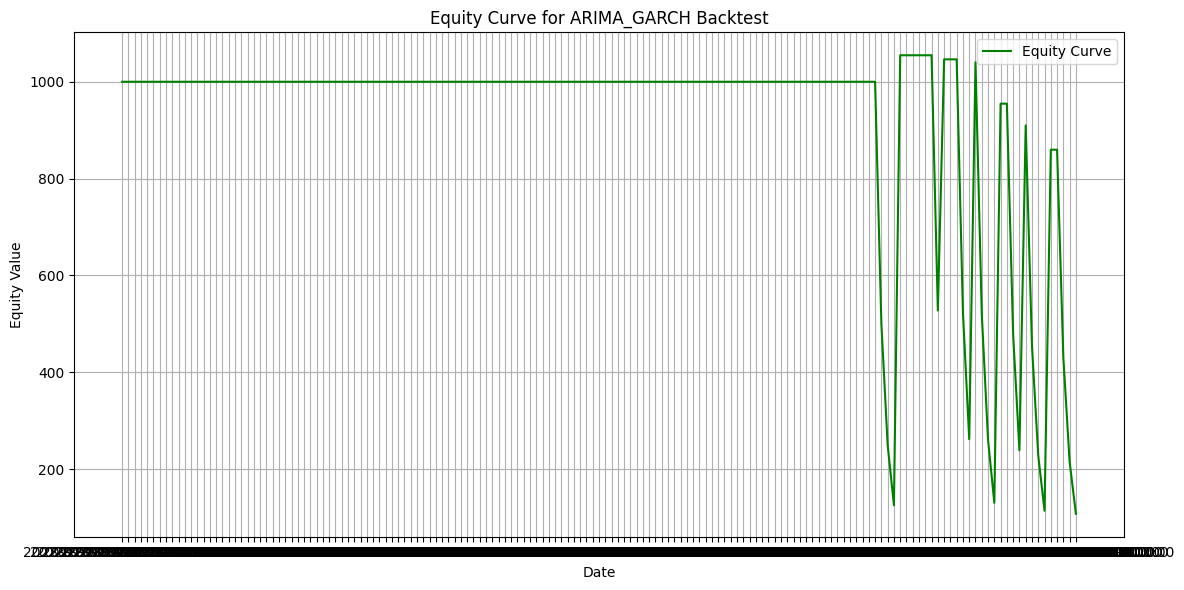

In [45]:
# equity_values
plt.figure(figsize=(12, 6))
plt.plot(backtest['Date'], ARIMA_GARCH_equity_values, label='Equity Curve', color='green')
plt.title('Equity Curve for ARIMA_GARCH Backtest')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

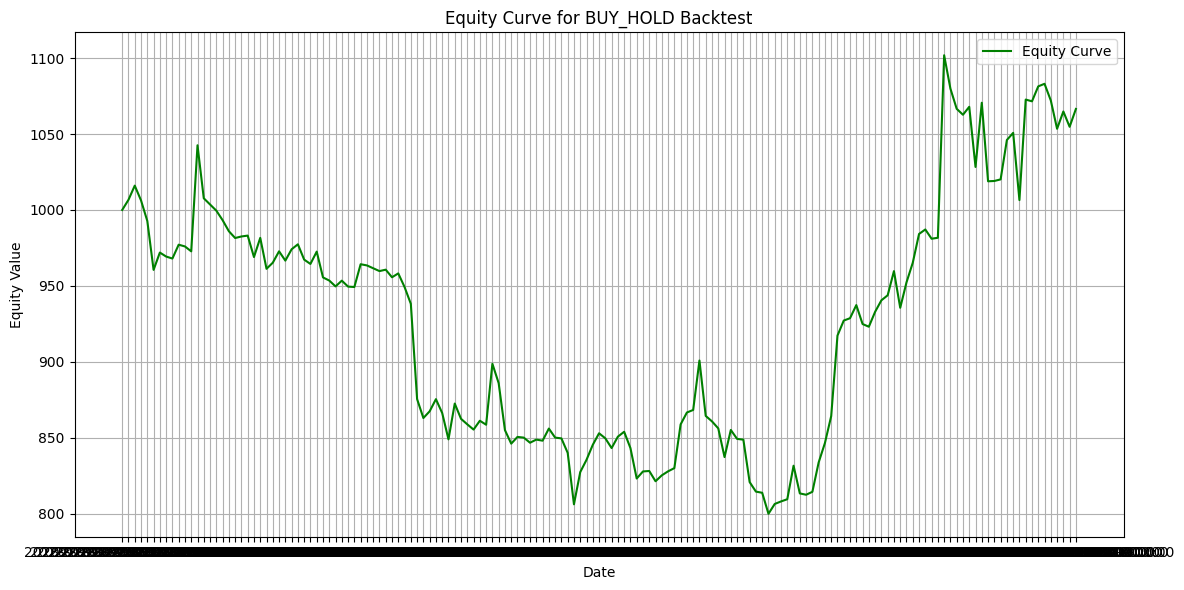

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(backtest['Date'], BUY_HOLD_equity_values, label='Equity Curve', color='green')
plt.title('Equity Curve for BUY_HOLD Backtest')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()